In [1]:
import nengo
import nengo_spa as spa
import numpy as np
from random import shuffle
import random


use_ocl = True
if use_ocl:
    import nengo_ocl
    simulator = nengo_ocl.Simulator
else:
    simulator = nengo.Simulator
    
import sys, os

sys.path.append('..')
import experiments as xps
from modules import Processor

import math
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline
default_cycler = cycler('color', ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'])
plt.rc('axes', prop_cycle=(default_cycler))

from IPython import display


# Model variables

In [2]:
if True: # random seed
    seed = np.random.randint(999)
    print("Warning: setting random seed")
else:
    seed = 1
    
np.random.seed(seed)
random.seed(seed)
s = spa.sym
D = 128*6  # the dimensionality of the vectors
D_GW = 128*6  # the dimensionality of the vectors in GW
PROC_FDBCK = 0
GW_FDBCK = .9
GW_THR = .5
ROUTING_THR = .1
ROUTING_BIAS = .5
broadcast_source = ["processors","GW"][1]

# Number of neurons (per dimension or ensemble)
scale_npds = 1
npd_AM = int(50*scale_npds) # Default: 50
npd_state = int(50*scale_npds) # Default: 50
npd_BG = int(100*scale_npds) # Default: 100
npd_thal1 = int(50*scale_npds) # Default: 50
npd_thal2 = int(40*scale_npds) # Default: 40
n_scalar = int(50*scale_npds) # Default: 50

n_blocks_per_operation = 1 # default: 10
n_trials_per_digit = 1 # default: 5
n_different_digits = 2 # default: 4
n_different_operations = 1 # default: 3

number_of_total_trials = n_blocks_per_operation * n_trials_per_digit * n_different_digits * n_different_operations
number_of_non_learning_trials = number_of_total_trials
number_of_learning_trials = max(0,number_of_total_trials - number_of_non_learning_trials)
print("number_of_learning_trials",number_of_learning_trials) 
print("number_of_non_learning_trials",number_of_non_learning_trials) 
print("number_of_total_trials",number_of_total_trials)


add_ON = True
keys = ['TWO','FOUR','SIX','EIGHT','X', \
               'MORE','LESS', \
    'G', 'V', 'COM', 'ADD', 'SUB', \
    'SIMPLE', 'CHAINED_ADD', 'CHAINED_SUB', \
               'ON'
    ] + ['V_COM', 'COM_PM', 'V_ADD', 'V_SUB', 'ADD_COM', 'SUB_COM']

vocab = spa.Vocabulary(dimensions=D, pointer_gen=np.random.RandomState(seed), max_similarity=.02)
vocab_GW = spa.Vocabulary(dimensions=D_GW, pointer_gen=np.random.RandomState(seed), max_similarity=.02)

for voc in [vocab, vocab_GW]:
    voc.populate(";".join(keys))
vocab_GW.populate(";".join([p+"_ON=ON*"+p for p in ['V', 'COM', 'ADD', 'SUB']])) # this is done to avoid similarity with other SPs

trials = xps.createTrials(n_blocks_per_operation, n_trials_per_digit, n_different_digits, n_different_operations, shuffle=True)
#xp = xps.Xp1(number_of_learning_trials, trials, fixation="0")
xp = xps.TestMasking(.083, number_of_learning_trials, trials, fixation="0")

T = number_of_total_trials * xp.trial_length - .00001# simulations run a bit too long
print('T',T)

number_of_learning_trials 0
number_of_non_learning_trials 2
number_of_total_trials 2
T 4.05799


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.02 (D=768, M=10, similarity=0.02)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.02 (D=768, M=11, similarity=0.02)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.02 (D=768, M=13, similarity=0.02)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.02 (D=768, M=14, similarity=0.03)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: Use

# Create model

In [3]:
np.random.seed(seed)
random.seed(seed)

model = spa.Network(seed=seed)
with model:
    
    model.config[spa.State].neurons_per_dimension = npd_state
    model.config[spa.Scalar].n_neurons = n_scalar
    model.config[spa.BasalGanglia].n_neurons_per_ensemble = npd_BG
    model.config[spa.Thalamus].neurons_action = npd_thal1
    model.config[spa.Thalamus].neurons_channel_dim = npd_thal1
    model.config[spa.Thalamus].neurons_gate = npd_thal2
    
    inputs_net = spa.Network(label='inputs')

    # We start defining the buffer slots in which information can
    # be placed:
    
    # A slot for the visual input (the digit N). Feedback is used for iconic memory (100-300ms)
    V_mapping = ['TWO','FOUR','SIX','EIGHT','X']
    """RETINA = spa.WTAAssocMem(
        0.1,
        vocab,
        mapping=V_mapping,
        function=lambda x: (x>0)*0.0015,
        n_neurons = npd_AM
    )
    nengo.Connection(RETINA.output, RETINA.output, transform=.9995, synapse=.0001)"""
    with inputs_net:
        RETINA_input = spa.Transcode(xp.RETINA_input,output_vocab = vocab)
        
    V = Processor(
        vocab, vocab_GW, 'V', V_mapping, filter_thr=GW_THR, feedback=PROC_FDBCK, add_ON=add_ON, AM_cls=spa.ThresholdingAssocMem,
        npd_AM=npd_AM, broadcast_source=broadcast_source, seed=seed
    )
#     RETINA.output >> V.input_state
    nengo.Connection(RETINA_input.output, V.input_state.input, synapse=None)
    
    1/2 >> V.attention
    
    # A slot that combines selected information from the processors
    with nengo.Network() as GW_net:
        GW_net.config[nengo.Ensemble].radius = .5
        GW = spa.State(vocab_GW, label='GW', feedback=GW_FDBCK, feedback_synapse=.05)
    
    processors = [V]
    """for p in processors:
        if p.sender:
            p.filter >> GW"""
    
    # access network
    access_labels = []
    with spa.Network(label='conscious access') :
        for p in processors:
            if p.sender:
                with spa.ActionSelection():
                    for sym in ['TWO','FOUR','SIX','EIGHT','X']:
                        spa.ifmax(sym, ROUTING_BIAS+spa.dot(p.preconscious, vocab.parse(sym)),
                                    0.4*(vocab_GW.parse(sym) * vocab_GW.parse(p.label)) >> GW,
                                 )
#             access_labels.append("Thresholder")
                    spa.ifmax(.7)
    
    


# Set up some probes

In [4]:
with model:
    
    probe_dt = .05
    probe_synapse = .01

    p_RETINA_in = nengo.Probe(RETINA_input.output, synapse = probe_synapse)#, sample_every = probe_dt)
#     p_RETINA = nengo.Probe(RETINA.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_V = nengo.Probe(V.input_state.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_V_out = nengo.Probe(V.AM.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_GW = nengo.Probe(GW.output, synapse = probe_synapse)#, sample_every = probe_dt)
    
    """p_access_in = nengo.Probe(access.bg.input, synapse = probe_synapse)
    p_access_out = nengo.Probe(access.bg.output, synapse = probe_synapse)"""


# Run the model

In [5]:
dt = .001
print("Number of neurons:", model.n_neurons)
print("T:",T)
with simulator(model, dt = dt, seed=seed) as sim:
    sim.run(T)

Number of neurons: 80400
T: 4.05799
No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

# Plot results

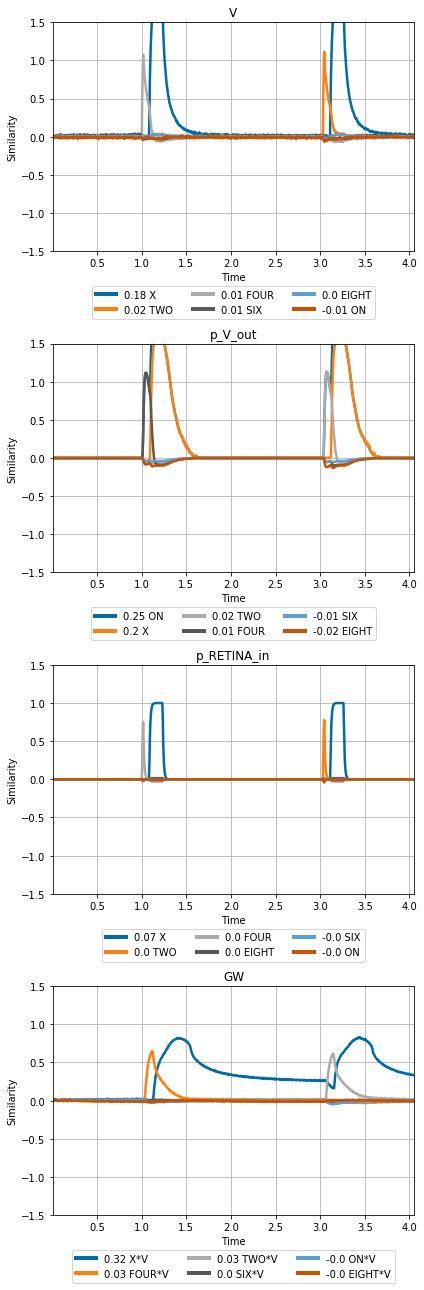

In [6]:
if True:
    
    def plot_similarities(t_range, data, vocab, keys=False, autoscale=False, title='Similarity', sort_legend=True, permutation=None, subplot_nrows=0, subplot_ncols=0, subplot_i = 1):

        if not keys:
            keys = list(vocab.keys())

        if subplot_nrows * subplot_ncols > 0:
            plt.subplot(subplot_nrows,subplot_ncols,subplot_i)

        if permutation is None:
            permutation = range(vocab.dimensions)
        vectors = np.array([vocab.parse(p).v @ np.identity(vocab.dimensions)[permutation] for p in keys])
        mean_activation = spa.similarity(data, vectors).mean(axis=0)
        sort_idx = np.argsort(mean_activation)[::-1]    

        ymin, ymax = -1.5, 1.5
        plt.ylim(ymin, ymax)
        plt.autoscale(autoscale, axis='y')
        plt.grid(True)
        plt.plot(t_range, spa.similarity(data, vectors[sort_idx]), linewidth=2.5)
        plt.title(title)
        plt.xlabel("Time")
        plt.ylabel("Similarity")
        plt.xlim(left=t_range[0], right=t_range[-1])
        #plt.xticks(np.arange(t_range[0], t_range[-1], xp.trial_length))
        leg = plt.legend([str(round(mean_activation[sort_idx][i],2))+' '+k for i,k in enumerate(np.array(keys)[sort_idx])], loc='upper center',
                   bbox_to_anchor=(0.5, -0.13), ncol=3)
        
        # set the linewidth of each legend object
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
            
        if subplot_nrows * subplot_ncols == 0:
            plt.show()

        return subplot_i + 1



    subplot_nrows=4
    subplot_ncols=1
    plt.figure(figsize=(6*subplot_ncols,4.5*subplot_nrows))
    
    def trial_t(trial_number):
        return trial_number*xp.trial_length
    
    focus_start = 0 # first trial to plot
    n_focus = 3 # how many trials to plot
    start = trial_t(focus_start)
    end = trial_t(focus_start+n_focus)
    skip = 5
    trange = sim.trange()
    selected_idx = np.where(np.logical_and(trange > start, trange < end))
    trange = trange[selected_idx][::skip]


    subplot_i=plot_similarities(trange, sim.data[p_V][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT', 'ON','X'], title='V', subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_V_out][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT', 'ON','X'], title='p_V_out', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_RETINA_in][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT', 'ON','X'], title='p_RETINA_in', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
#     subplot_i=plot_similarities(trange, sim.data[p_RETINA][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT', 'ON','X'], title='p_RETINA', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_GW][selected_idx][::skip], vocab, keys=[k+'*V' for k in ['TWO','FOUR','SIX','EIGHT','ON','X']], title='GW', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    
    
    plt.tight_layout()

    plt.show()
    
    


In [7]:
plt.figure(figsize=(18,12))
for i in range(access.bg.input.size_out):
    plt.subplot(1,access.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx][::skip], sim.data[p_access_in][:,i][selected_idx][::skip])
    plt.title(access_labels[i])
    plt.ylim(-.5,1)

plt.show()

plt.figure(figsize=(18,12))
for i in range(access.bg.input.size_out):
    plt.subplot(1,access.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx][::skip], sim.data[p_access_out][:,i][selected_idx][::skip])
    plt.title(access_labels[i])
    plt.ylim(-1.5,.5)

plt.show()

NameError: name 'access' is not defined

<Figure size 1296x864 with 0 Axes>